In [1]:
from collections import defaultdict
import pennylane as qml
import pennylane.numpy as np
from qiskit.visualization import plot_bloch_multivector
from tqdm import trange

from math import pi
from data import routes,labels,relations

![graph](./assets/graph.png)

In [51]:
fartest_point = max(list(relations.values()))

In [52]:
encode_angle = lambda x: (x*pi)/fartest_point
def embedding(input_data, n_qubits):
    qml.AngleEmbedding(features=[encode_angle(angle) for angle in input_data], wires=range(n_qubits), rotation="Y")

In [53]:
def ansatz(weights, n_qubits):
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_qubits), rotation=qml.RX)

In [54]:
def model(input_data, weights, n_qubits):
    embedding(input_data, n_qubits)
    ansatz(weights,n_qubits)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    
def train(root):
    root.visited = True
    current_node = root

    paths = defaultdict(int)
    path_index = 0

    while True:
        path_size = 0
        weights_mem = {}
        path_data = {}
        
        while(not current_node.is_leaf()):
            print(f'Current node: {current_node.label}')
        
            n_qubits = len(current_node.next)
            device = qml.device('qiskit.aer', wires=n_qubits)
            model_func = qml.QNode(func=model, device=device)
    
            weights = np.random.uniform(0, pi, size=(1,2,n_qubits))
            weights_mem[n_qubits] = weights
            
            input_data = [node.value for node in current_node.next]
            result = model_func(input_data, weights, n_qubits)
            
            min_value_index = result.index(min(result))
            current_node = current_node.next[min_value_index]
            path_size += current_node.value
            
        path_index+=1
    
    

    return path_size, weights_mem

In [47]:
train(routes)

Current node: A
Current node: D
Current node: B
Current node: C


(18.7,
 {4: [tensor([[[2.45867508, 2.00516754, 1.43245673, 1.18889271],
            [0.87817983, 2.96762048, 2.8894969 , 2.48377236]]], requires_grad=True)],
  3: [tensor([[[2.2148994 , 1.67419492, 1.19358338],
            [2.15926875, 2.17581134, 0.40934864]]], requires_grad=True)],
  2: [tensor([[[1.19037417, 1.95678056],
            [1.60964696, 0.21763835]]], requires_grad=True)],
  1: [tensor([[[1.19301116],
            [1.88096293]]], requires_grad=True)]})

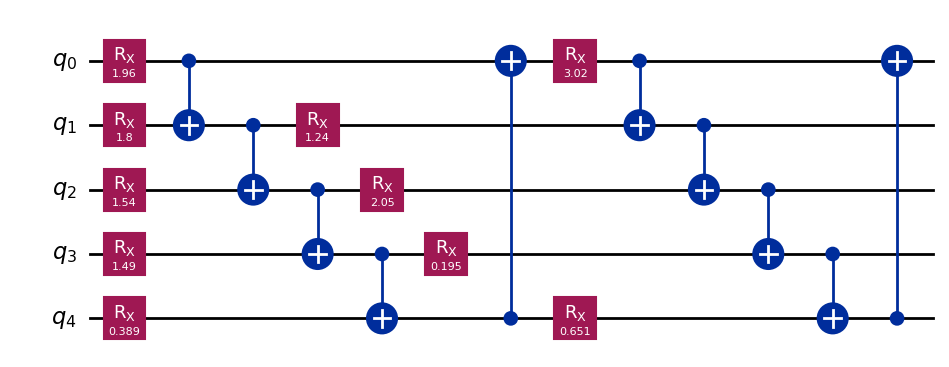

In [35]:
# ansatz example


@qml.qnode(examples)
def ansatz_example(weights):
    ansatz(weights)
    return qml.probs(wires=range(n_qubits))

ansatz_example(initial_weights_example)
examples._circuit.remove_final_measurements()
examples._circuit.draw("mpl")

---

In [41]:
hamiltonian = qml.Hamiltonian([1.0]*n_qubits, [qml.PauliZ(i) for i in range(n_qubits)])

In [44]:
@qml.qnode(train)
def train_model(input_data, weights):
    embedding(input_data)
    ansatz(weights)
    return qml.expval(hamiltonian)


In [45]:
train_model(input_data,initial_weights_example)
train._circuit.remove_final_measurements()

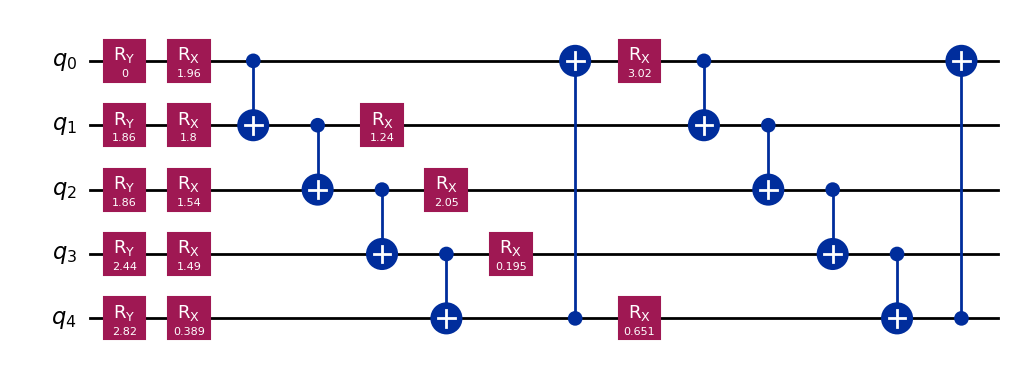

In [46]:
train._circuit.draw('mpl')

In [54]:
EPOCHS = 10
NUM_WEIGHTS_PER_LAYER = 5
weights = np.random.uniform(0, pi, size=(1,2,NUM_WEIGHTS_PER_LAYER))

opt = qml.AdamOptimizer()

points = data['from'].unique().tolist()

for _ in trange(EPOCHS):
    for i in points:
        input_data = data.loc[data['from'] == i]['weight'].tolist()
        
        print(i,input_data)
        print(train_model(input_data,weights), i)
        #weights, prev_cost = opt.step_and_cost(train_model, input_data, weights)


  0%|                                                                                                                                                                                 | 0/10 [00:00<?, ?it/s]

A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.140625 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
0.015625 B
C [7.1, 1.7, 0.0, 3.5, 4.7]


 10%|████████████████▉                                                                                                                                                        | 1/10 [00:00<00:03,  2.27it/s]

-0.02734375 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.357421875 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
0.1796875 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
0.0078125 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.17578125 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.0625 C
D [8.7, 4.0, 3.4, 0.0, 1.4]


 20%|█████████████████████████████████▊                                                                                                                                       | 2/10 [00:00<00:03,  2.32it/s]

-0.21484375 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
0.029296875 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.123046875 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.154296875 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
0.005859375 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.22265625 D
E [9.8, 5.1, 4.5, 1.4, 0.0]


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 3/10 [00:01<00:03,  2.32it/s]

-0.103515625 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.076171875 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.0390625 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.052734375 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.333984375 D
E [9.8, 5.1, 4.5, 1.4, 0.0]


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 4/10 [00:01<00:02,  2.18it/s]

-0.0234375 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.064453125 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.01953125 B
C [7.1, 1.7, 0.0, 3.5, 4.7]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 5/10 [00:02<00:02,  2.26it/s]

-0.087890625 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.259765625 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
0.046875 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.095703125 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.001953125 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.099609375 C
D [8.7, 4.0, 3.4, 0.0, 1.4]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 6/10 [00:02<00:01,  2.28it/s]

-0.345703125 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
-0.02734375 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.12890625 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.060546875 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.0703125 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.328125 D
E [9.8, 5.1, 4.5, 1.4, 0.0]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7/10 [00:03<00:01,  2.30it/s]

-0.021484375 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.015625 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.1171875 B
C [7.1, 1.7, 0.0, 3.5, 4.7]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8/10 [00:03<00:00,  2.29it/s]

-0.017578125 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.32421875 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
0.013671875 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
-0.076171875 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.080078125 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.087890625 C
D [8.7, 4.0, 3.4, 0.0, 1.4]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9/10 [00:03<00:00,  2.32it/s]

-0.25390625 D
E [9.8, 5.1, 4.5, 1.4, 0.0]
-0.11328125 E
A [0.0, 5.8, 5.8, 7.6, 8.8]
0.041015625 A
B [5.3, 0.0, 2.4, 4.3, 4.3]
-0.0625 B
C [7.1, 1.7, 0.0, 3.5, 4.7]
-0.0625 C
D [8.7, 4.0, 3.4, 0.0, 1.4]
-0.20703125 D
E [9.8, 5.1, 4.5, 1.4, 0.0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]

-0.033203125 E
